In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import re
import time
%matplotlib
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import textwrap
import scipy.stats as stats

from scipy import stats
import scipy
from functools import partial

import matplotlib.pylab as pylab
import seaborn as sns
sns.set_style('whitegrid', {'legend.frameon':True})
sns.set_palette(sns.color_palette("Set1", 12))
#sns.set_context("paper")
fontsize = 12
params = {'legend.fontsize': fontsize,
  'figure.figsize': (18, 15),
  'axes.labelsize': fontsize,
  'axes.titlesize':fontsize,
  'axes.edgecolor':"0.3",
  'xtick.labelsize':fontsize,
  'ytick.labelsize':fontsize,
  'legend.fontsize':10,
  'font.size':fontsize,
  'font.family':'serif'}
pylab.rcParams.update(params)
plt.rc('axes', labelsize=fontsize) 

#plt.style.use('ggplot')
%matplotlib inline

from tqdm.notebook import tqdm
import pandas as pd
from pathlib2 import Path
import os

Using matplotlib backend: <object object at 0x000001FCEC684440>


In [3]:
import sys
sys.path.append('../')

from metric_store import save_metrics, save_metric, load_metrics, get_metric_names, load_metric
from network_metrics import prepare_metric
from pipeline.pipeline import load_config

In [4]:
config_name = "pipeline.config"
config = load_config(config_name)

In [5]:
from corr_network import load_data, get_available_mask
data = load_data(config)
available_mask = get_available_mask(data)

In [30]:
metric_name = 'input_data/MSLP_preproc'    
config.metrics_plot_options['metric_name'] = metric_name
input_data = load_metric(config, metric_name)
input_data = prepare_metric(metric_name, input_data, available_mask)
print(metric_name, input_data.shape, config.metric_dimension[metric_name])

input_data/MSLP_preproc (36, 69, 113960) 2D


In [8]:
data = np.load('../cyclones_events.npz')
list(data.keys())
cyclone_events = data['cyclone_events_2']

In [46]:
nt = input_data.shape[2]
start_lat, end_lat = 10, 30
start_lon, end_lon = 30, 60
start_frame = nt - 1000
end_frame = nt
input_data_sample = input_data[start_lat:end_lat, start_lon:end_lon, start_frame:end_frame]
cyclone_events_sample = cyclone_events[start_lat:end_lat, start_lon:end_lon, start_frame:end_frame]
available_mask_sample = available_mask[start_lat:end_lat, start_lon:end_lon]

In [47]:
from network_metrics.clustering_coef import compute_weighted_clustering_coefficient
from helpers.parallel_maker import parallel_execute, make_args

def compute_metric(result, corr_matricies, ids):
    for tid in ids:
        corr_matrix = corr_matricies[tid].copy()
        LCC_w, _ = compute_weighted_clustering_coefficient(corr_matrix)
        result['LCC_w'][tid]       = LCC_w

def parallel_compute_metric(config, corr_matricies):
    from functools import partial
    num_threads = config.network_metrics['num_threads']
    result = {}
    corr_thrs = config.network_metrics['corr_thrs']
    result.update({
        'LCC_w':        np.zeros((corr_matricies.shape[0], corr_matricies.shape[1]), dtype = np.float32)
    })
    parallel_execute(num_threads, compute_metric, make_args(num_threads, result, corr_matricies))
    return result


In [54]:
from tqdm import tqdm
from network_metrics import combine_metric_parts
from corr_network.corr_network \
    import make_correlation_matricies, \
        get_available_data, \
        calc_parallel_online_optimized, \
        get_parts


config.correlations['num_threads'] = 4
config.correlations['num_parts'] = 10
config.network_metrics['corr_thrs'] = [None]
config.network_metrics['selected_metrics'] = ['LCC']

def make_correlation_matricies(config, data):
    delay_time = config.correlations['delay_time']
    window_size = config.correlations['window_size']
    num_threads = config.correlations['num_threads']
    
    if 'num_parts' in config.correlations:
        num_parts = config.correlations['num_parts']
        id_part = config.correlations['id_part']
        pos_part, len_part = get_parts(id_part, num_parts, data.shape[1])
        shifted_pos = max(0, pos_part - window_size - delay_time)
        data = data[:, shifted_pos:pos_part + len_part]
    result = calc_parallel_online_optimized(
        data, delay_time, window_size, num_threads, output_level=config.correlations['output_level']
    )
    if 'num_parts' in config.correlations:
        if id_part != 0:
           result = result[:, :, window_size + delay_time:]

    return result

def make_network_metric(config, input_data_sample, available_mask_sample):
    metrics = []
    data = get_available_data(input_data_sample, available_mask_sample)

    for id_part in tqdm(range(config.correlations['num_parts'])):
        config.correlations['id_part'] = id_part
        corr_networks = make_correlation_matricies(config, data)
        corr_networks = np.moveaxis(corr_networks, -1, 0)
        res = parallel_compute_metric(config, corr_networks)
        metrics += [res]

    metrics = combine_metric_parts(config, metrics)
    metric_name = 'network_metrics\\LCC_w'
    metric = metrics[metric_name]
    metric = prepare_metric(metric_name, metric, available_mask_sample)
    return metric


In [93]:
from metrics_probability.metrics_probability import compute_probability_for_metrics

train_metric = make_network_metric(config, input_data_sample, available_mask_sample)
prob = compute_probability_for_metrics(train_metric, train_metric)

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


In [91]:
prob = compute_probability_for_metrics(metric, metric)

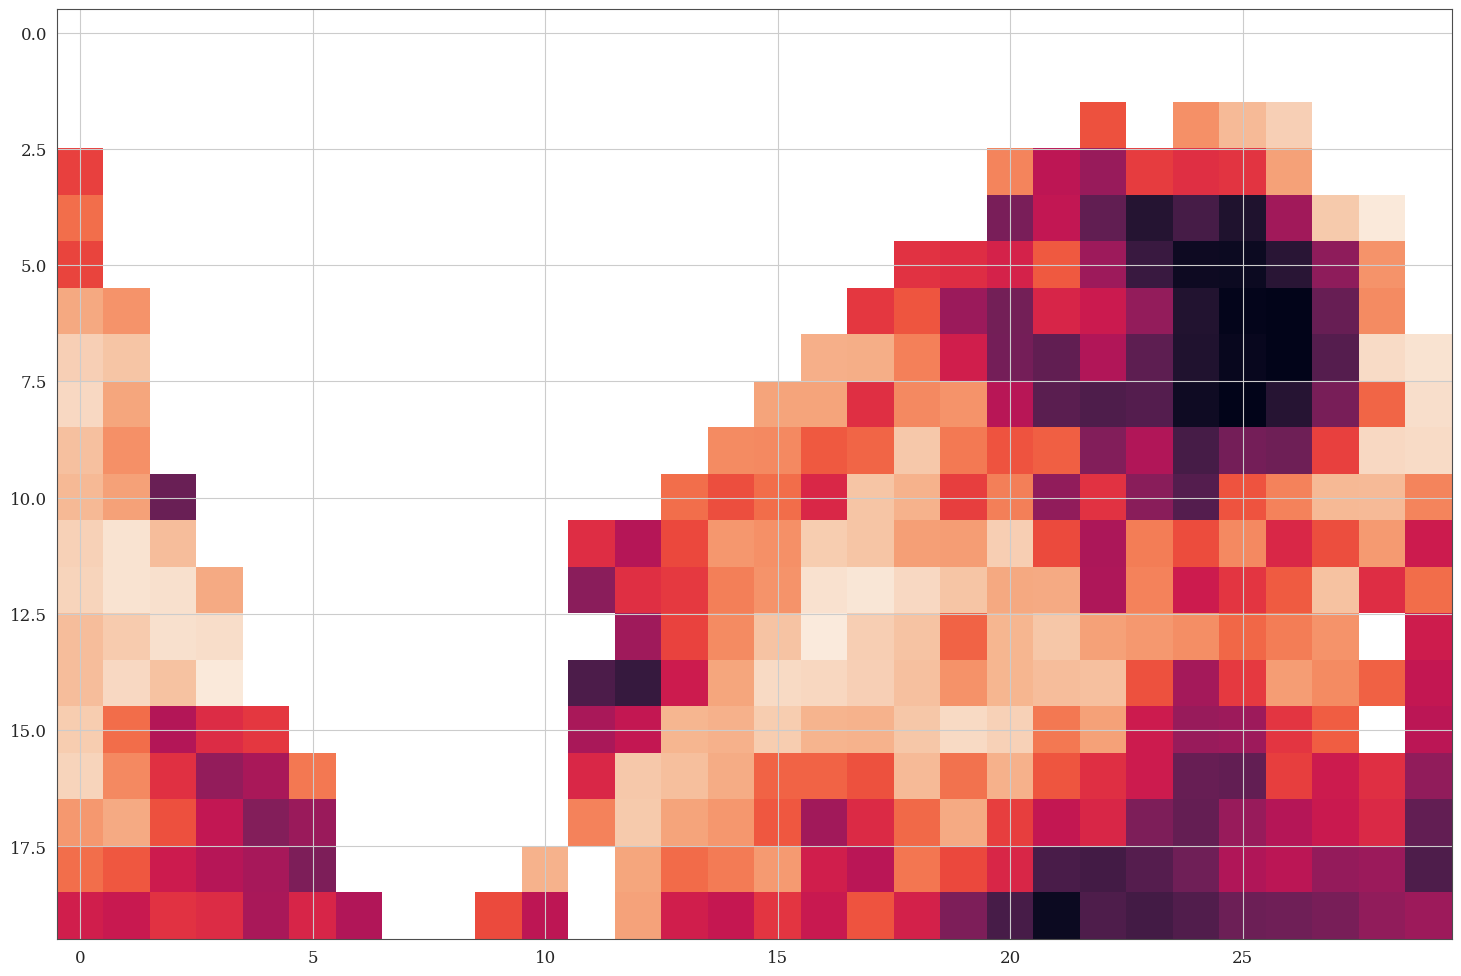

In [92]:
plt.imshow(prob[:, :, 201])